# Data Preparation

In [2]:
%matplotlib inline
from pathlib import Path

# Set the paths for data, pickle files, embeddings and saved models

datapath = Path('./data/')
modelpath = Path('./models/')
embeddingpath = Path('./embeddings/')
picklepath = Path('./pickles/')

### First we read the data and get a brief overview/class breakdown

There are 23036 companies in this dataset distributed among the following 10 categories:



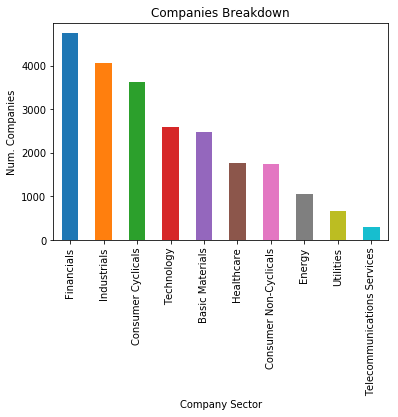

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = datapath / 'Data_ML.xlsx'
raw_data = pd.read_excel(data)
raw_descriptions = raw_data['Business Description']
raw_labels = raw_data['TRBC Economic Sector Name']
print('There are ' + '{}'.format(len(raw_data)) + ' companies in this dataset distributed among the following ' + '{}'.format(len(set(raw_labels))) + ' categories:\n')

plot = raw_labels.value_counts().plot.bar(title='Companies Breakdown')
plot.set(xlabel='Company Sector', ylabel='Num. Companies')
plt.show()

### From the class distribution we can see that there is class imbalance and therefore, accuracy is probably not the best metric to evaluate on and optimize for. More sophisticated metrics that take class imbalance into account such as the F1 score and/or the confusion matrix would be more appropriate metrics to evaluate on and to optimize for

### We could also tune weights in the loss function for the different classes or consider undersampling/oversampling/synthetic examples

### The second step is to search for missing values in the descriptions and/or the labels and remove them

There are 14 datapoints without a description distributed in the following categories:


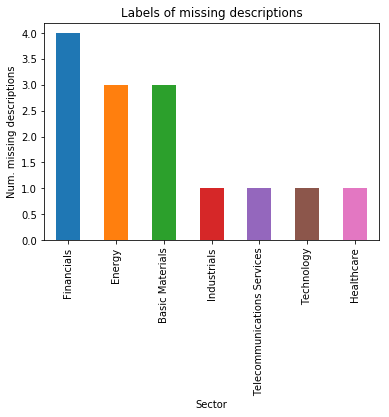

In [4]:
# Search for missing descriptions and their labels, plot them if there are any

missing_desc = raw_descriptions[pd.isna(raw_descriptions)]
missing_desc_labels = raw_labels[pd.isna(raw_descriptions)]
if len(missing_desc) > 0:
    print('There are ' + '{}'.format(len(missing_desc)) + ' datapoints without a description distributed in the following categories:')
    plot = missing_desc_labels.value_counts().plot.bar(title='Labels of missing descriptions')
    plot.set(xlabel='Sector', ylabel='Num. missing descriptions')
    plt.show()
else: 
    print('All companies have a description!')

In [5]:
# Search for missing labels, plot them if there are any

missing_labels = raw_labels[pd.isna(raw_labels)]
if len(missing_labels) > 0:
    print('There are ' + '{}'.format(len(missing_labels)) + ' datapoints without a label distributed in the following categories:')
    plot = missing_labels.value_counts().plot.bar(title='Missing labels')
    plot.set(xlabel='Sector', ylabel='Num. missing labels')
    plt.show()
else:
    print('All companies have a label')

All companies have a label


After removing the missing entries, the dataset now contains 23022 datapoints distributed in the categories as follows:



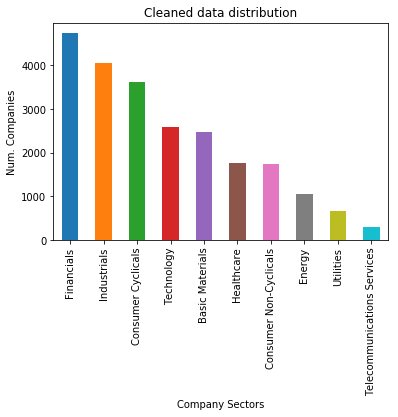

In [6]:
# Clean the data by dropping the missing rows and plot the cleaned data distribution

dataframe = pd.concat([raw_descriptions, raw_labels], axis=1)
clean_df = dataframe.dropna()
descriptions = clean_df.iloc[:, 0]
labels = clean_df.iloc[:, 1]
print('After removing the missing entries, the dataset now contains ' + '{}'.format(len(clean_df)) + ' datapoints distributed in the categories as follows:\n')
plot = labels.value_counts().plot.bar(title='Cleaned data distribution')
plot.set(xlabel='Company Sectors', ylabel='Num. Companies')
plt.show()

### Next we ceate a function that cleans the documents: All words are coverted to lower case, punctuation and stopwords are removed, contracted forms are replaced by original forms and lemmatization is performed

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')


def text_cleaner(text, stem=False):
    
    """
    Args: 
        text: the text to be cleaned
        stem: if True stemming will be performed on top of lemmatization
    
    Returns: 
        a lemmatized (optinally stemmed) text, free of uppercase letters, punctuation, stopwords and some contracted forms
    """

    text = text.lower().split()
    
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'[^\w\s]', " ", text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    if stem:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    
    return text

[nltk_data] Downloading package stopwords to C:\Users\Bill-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Bill-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Use the cleaning function to format the company descriptions

descriptions = descriptions.map(lambda x: text_cleaner(x))

In [9]:
# An example description

print(descriptions.iloc[5])

bhp billiton limited global resource company company producer various commodity including iron ore metallurgical coal copper uranium segment include petroleum copper iron ore coal petroleum segment engaged exploration development production oil gas copper segment engaged mining copper silver lead zinc molybdenum uranium gold iron ore segment engaged mining iron ore coal segment engaged mining metallurgical coal thermal energy coal business include mineral australia mineral america petroleum marketing company extract process mineral oil gas production operation located primarily australia america company manages product distribution global logistics chain including freight pipeline transportation business include mineral australia mineral america petroleum marketing


### Tokenize the descriptions and pad them, create 1-hot labels, 

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)
x_data = tokenizer.texts_to_sequences(descriptions)

Using TensorFlow backend.


In [11]:
import numpy as np

# Get word index, and the maximum word and description length

word_index = tokenizer.word_index
max_word_len = np.max([len(word) for word in word_index])
max_desc_len = np.max([len(desc) for desc in descriptions])
print('The maximum word length is equal to {}'.format(max_word_len))
print('The maximum description length is equal to {}'.format(max_desc_len))

The maximum word length is equal to 40
The maximum description length is equal to 901


In [12]:
from keras.preprocessing.sequence import pad_sequences

# Padding to max length

x_data = pad_sequences(x_data, maxlen=max_desc_len)

In [13]:
from sklearn import preprocessing
from keras.utils import to_categorical

# Convert the labels to one-hot

label_encoder = preprocessing.LabelEncoder()
y_data = label_encoder.fit_transform([y for y in labels])
y_data = to_categorical(np.array(y_data))

### Shuffle the data, split them to train/validation/test and save them

In [14]:
def shuffle(x_data, y_data, seed=0):
    """
    Shuffles the training examples and their labels preserving the corresponding order
     
    Args: 
        x_data: the training examples
        y_data: the corresponding labels
        seed (optional) : numpy seed so random split is reproducible (default=0)
        
    Returns: 
        x_data: a shuffled version of the data 
        y_data: a shuffled version of the labels
    """   
    
    # Check if x_data and y_data are of the same dimension
    try:
        assert(len(x_data) == len(y_data))
    except AssertionError:
        raise(AssertionError('Dimension mismatch!', '{}'.format(len(y_data))  + ' != ' + '{}'.format(len(x_data)))) 
    
    # Set the seed
    np.random.seed(seed)
    indices = np.arange(len(x_data))
    
    # Shuffle
    np.random.shuffle(indices)
    x_data = x_data[indices]
    y_data = y_data[indices]
    
    return x_data, y_data

# Shuffle the data

x_data, y_data = shuffle(x_data, y_data)

In [15]:
from sklearn.model_selection import train_test_split

def split(x_data, y_data, val_size, test_size):
    """
    Splits the data to train, validation, test using sklearns build-in train_test_split function twice
     
    Args: 
        x_data: the training examples
        y_data: the corresponding labels
        val_size: the validation set split percentage
        test_size: the test set split percentage
        
    Returns: 
        data_dict: a dictionary containing six datasets: x_data, y_data, x_val, y_val, x_test, y_test
    """      
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data, test_size=test_size)
    x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                    y_train, test_size=val_size/(1-test_size))
    
    return {'x_train': x_train, 'x_val': x_val, 'x_test': x_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

# Split the data

data_dict = split(x_data, y_data, test_size=0.2, val_size=0.2)

In [16]:
# A final check that dimensions are correct and the train/validation/test distributions are roughly even

print('Size of training data = {}'.format(data_dict['x_train'].shape))
print('Size of validation data = {}'.format(data_dict['x_val'].shape))
print('Size of test data = {}'.format(data_dict['x_test'].shape))
print('Training set distribution = {}'.format(np.mean(data_dict['y_train'],axis=0)))
print('Training set distribution = {}'.format(np.mean(data_dict['y_val'],axis=0)))
print('Training set distribution = {}'.format(np.mean(data_dict['y_test'],axis=0)))

Size of training data = (13812, 901)
Size of validation data = (4605, 901)
Size of test data = (4605, 901)
Training set distribution = [0.10606719 0.15739936 0.07471763 0.04510571 0.20663191 0.07971329
 0.17658558 0.11410367 0.01274254 0.0269331 ]
Training set distribution = [0.11400651 0.15027145 0.06948969 0.04647123 0.20933768 0.07926168
 0.17263843 0.10836048 0.01368078 0.03648208]
Training set distribution = [0.10705755 0.1630836  0.08317047 0.04885994 0.20086862 0.0660152
 0.17698154 0.11226927 0.01476656 0.02692725]


In [22]:
# Save the cleaned data

np.savetxt(datapath / 'x_train.csv',data_dict['x_train'],  delimiter=',')
np.savetxt(datapath / 'y_train.csv',data_dict['y_train'], delimiter=',')
np.savetxt(datapath / 'x_val.csv',data_dict['x_val'], delimiter=',')
np.savetxt(datapath / 'y_val.csv',data_dict['y_val'], delimiter=',')
np.savetxt(datapath / 'x_test.csv',data_dict['x_test'], delimiter=',')
np.savetxt(datapath / 'y_test.csv',data_dict['y_test'], delimiter=',')

# Pre-training/optimization process

### Load the Glove embeddings and create the embeddings matrix

In [23]:
dim = 50
embeddings_idx ={}
embeddings = open(embeddingpath / 'glove.6B.50d.txt', encoding="utf8")
for line in embeddings:
    vectors = line.split()
    word = vectors[0]
    values = np.array(vectors[1:], dtype='float32')
    embeddings_idx[word] = values
embeddings.close()

embedding_matrix = np.zeros((len(word_index) + 1, dim))
for word, idx in word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

### Define precision, recall and f1 score to be used as metrics

In [24]:
# Keras callback class to evaluate the f1 score after every epoch and store it

import keras.backend as K
from keras.callbacks import Callback

class Metrics(Callback):
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_recall = recall_score(val_targ, val_predict, average='weighted')
        _val_precision = precision_score(val_targ, val_predict, average='weighted')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

# Precision, recall and fbeta score function to be used by Keras

def precision(y_true, y_pred):
    """
    Calculates the unweighted precision score
    
    Args: 
        y_true: the true labels
        y_pred: the predicted labels
    
    Returns:
        the precision score
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision


def recall(y_true, y_pred):
    """
    Calculates the unweighted recall score
    
    Args: 
        y_true: the true labels
        y_pred: the predicted labels
    
    Returns:
        the recall score
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """
    Calculates the unweighted fbeta score
    
    Args: 
        y_true: the true labels
        y_pred: the predicted labels
        beta: to specify an F score other than F1 (default=1)
    Returns:
        the fbeta score
    """
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    
    return fbeta_score

### Do some preliminary tests (20 epochs) using an LSTM (since we have sequencial data) and then a ConvLSTM to try to capture some spatial scructure and also reduce the LSTM input dimension (less training time)

In [25]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Activation, Embedding
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

glove = True
embedding_dim = 128

### LSTM Model

In [26]:
lstm_metrics = Metrics()

model = Sequential()
if glove:
    model.add(Embedding(len(word_index) + 1, 50, weights=[embedding_matrix],
                                input_length=max_desc_len, trainable=False))
else:
    model.add(Embedding(len(word_index) + 1, embedding_dim,
                            input_length=max_desc_len))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', fbeta_score])
model.summary()
callbacks=[lstm_metrics]
model.fit(data_dict['x_train'], data_dict['y_train'], validation_data=(data_dict['x_val'], data_dict['y_val']),
          epochs=20, batch_size=128, callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 901, 50)           3760650   
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               60400     
_________________________________________________________________
batch_normalization_15 (Batc (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 128)               12928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

C:\Users\Bill-PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Bill-PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 2/20
13812/13812 [==============================] - 339s - loss: 1.4008 - acc: 0.5300 - fbeta_score: 0.4735 - val_loss: 1.0514 - val_acc: 0.6708 - val_fbeta_score: 0.5508
Epoch 3/20
13812/13812 [==============================] - 340s - loss: 1.2261 - acc: 0.5855 - fbeta_score: 0.5352 - val_loss: 0.8984 - val_acc: 0.7040 - val_fbeta_score: 0.6626
Epoch 4/20
13812/13812 [==============================] - 342s - loss: 1.0652 - acc: 0.6447 - fbeta_score: 0.6031 - val_loss: 0.8004 - val_acc: 0.7357 - val_fbeta_score: 0.7204
Epoch 5/20
13812/13812 [==============================] - 344s - loss: 0.9687 - acc: 0.6734 - fbeta_score: 0.6473 - val_loss: 0.7481 - val_acc: 0.7488 - val_fbeta_score: 0.7434
Epoch 6/20
13812/13812 [==============================] - 344s - loss: 0.8972 - acc: 0.6940 - fbeta_score: 0.6724 - val_loss: 0.7137 - val_acc: 0.7633 - val_fbeta_score: 0.7561
Epoch 7/20
13812/13812 [==============================] - 358s - loss: 0.8390 - acc: 0.7157 - fbeta_score: 0.6987 

#### save the model and model weights in case needed

In [28]:
from keras.models import model_from_json

lstm_json = model.to_json()
with open(modelpath / "lstm.json", 'w') as json_file:
    json_file.write(lstm_json)
    
model.save_weights(modelpath / 'lstm.h5')

[0.19401111370736665, 0.49239807502251554, 0.62451479816528277, 0.70506508677898305, 0.72922814821679705, 0.7465340426082796, 0.7737718487336539, 0.7840894600062398, 0.79518117606330196, 0.79341570716088494, 0.79941449154747612, 0.80144403106380824, 0.80529473488431003, 0.80853781766608024, 0.81337108329285213, 0.81676831373028447, 0.8163359834371795, 0.82236713590881261, 0.82400913901013073, 0.82160286780168645]


### ConvLSTM Model

In [31]:
convlstm_metrics = Metrics()

model = Sequential()
if glove:
    model.add(Embedding(len(word_index) + 1, 50, weights=[embedding_matrix],
                                input_length=max_desc_len, trainable=False))
else:
    model.add(Embedding(len(word_index) + 1, embedding_dim,
                            input_length=max_desc_len))
model.add(Conv1D(128, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', fbeta_score])
model.summary()
callbacks=[convlstm_metrics]
model.fit(data_dict['x_train'], data_dict['y_train'], validation_data=(data_dict['x_val'], data_dict['y_val']),
          epochs=20, batch_size=128, callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 901, 50)           3760650   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 897, 128)          32128     
_________________________________________________________________
batch_normalization_18 (Batc (None, 897, 128)          512       
_________________________________________________________________
activation_10 (Activation)   (None, 897, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 224, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               91600     
_________________________________________________________________
batch_normalization_19 (Batc (None, 100)               400       
__________

C:\Users\Bill-PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Bill-PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 2/20
13812/13812 [==============================] - 146s - loss: 1.2319 - acc: 0.5771 - fbeta_score: 0.5219 - val_loss: 0.9980 - val_acc: 0.6606 - val_fbeta_score: 0.6190
Epoch 3/20
13812/13812 [==============================] - 132s - loss: 0.9921 - acc: 0.6639 - fbeta_score: 0.6312 - val_loss: 0.8523 - val_acc: 0.7129 - val_fbeta_score: 0.7053
Epoch 4/20
13812/13812 [==============================] - 130s - loss: 0.8745 - acc: 0.7005 - fbeta_score: 0.6766 - val_loss: 0.7331 - val_acc: 0.7579 - val_fbeta_score: 0.7548
Epoch 5/20
13812/13812 [==============================] - 128s - loss: 0.8135 - acc: 0.7263 - fbeta_score: 0.7087 - val_loss: 0.6779 - val_acc: 0.7718 - val_fbeta_score: 0.7715
Epoch 6/20
13812/13812 [==============================] - 128s - loss: 0.7516 - acc: 0.7513 - fbeta_score: 0.7342 - val_loss: 0.6581 - val_acc: 0.7828 - val_fbeta_score: 0.7828
Epoch 7/20
13812/13812 [==============================] - 128s - loss: 0.7110 - acc: 0.7630 - fbeta_score: 0.7531 

#### save the model and model weights in case needed

In [32]:
convlstm_json = model.to_json()
with open(modelpath / "convlstm.json", 'w') as json_file:
    json_file.write(convlstm_json)
    
model.save_weights(modelpath / 'convlstm.h5')

### Plot the F1 score on the validation set for both models for all 20 epochs

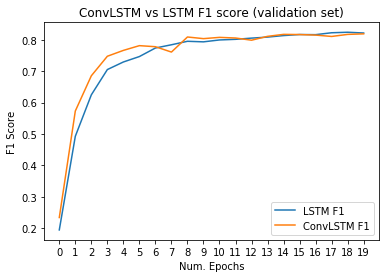

In [48]:
import matplotlib.pyplot as plt
epochs = np.arange(20)
lstm_val_f1 = lstm_metrics.val_f1s
convlstm_val_f1 = convlstm_metrics.val_f1s
plt.figure()
plt.plot(epochs, lstm_val_f1, label='LSTM F1')
plt.plot(epochs, convlstm_val_f1, label= 'ConvLSTM F1')
plt.title('ConvLSTM vs LSTM F1 score (validation set)')
plt.xlabel('Num. Epochs')
plt.ylabel('F1 Score')
plt.xticks([epoch for epoch in range(20)])
plt.legend()

# Optimization/Training

### Proceed with the ConvLSTM model (roughly same results but much less training time) and do some toy tuning

In [26]:
import tensorflow as tf
import numpy as np
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Activation, Embedding
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.models import Sequential, Model, model_from_json
import keras.backend as K
from keras.utils import np_utils
import pickle

### load the data, embeddings and word index

In [27]:
file = open(picklepath / 'embedding_matrix.pkl', 'rb')
embedding_matrix = pickle.load(file)

file = open(picklepath / 'word_index.pkl', 'rb')
word_index = pickle.load(file)

x_train = np.loadtxt(datapath / 'x_train.csv', delimiter=',')
y_train = np.loadtxt(datapath / 'y_train.csv', delimiter=',')
x_val = np.loadtxt(datapath / 'x_val.csv', delimiter=',')
y_val = np.loadtxt(datapath / 'y_val.csv', delimiter=',')
x_test = np.loadtxt(datapath / 'x_test.csv', delimiter=',')
y_test = np.loadtxt(datapath / 'y_test.csv', delimiter=',')

### create the model and data functions to be used by hyperas for tuning to be used by hyperas for hyperparameter tuning

In [22]:
def convlstm_tuner(x_train, y_train, x_val, y_val, word_index, embedding_matrix, max_desc_len):
    """
    model wrapper used for hyperas for optimization
    
    """
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision


    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall


    def fbeta_score(y_true, y_pred, beta=1):

        if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
            return 0

        p = precision(y_true, y_pred)
        r = recall(y_true, y_pred)
        bb = beta ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        
        return fbeta_score

    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 50, weights=[embedding_matrix],
                                input_length=max_desc_len, trainable=False))
    model.add(Conv1D({{choice([64, 128])}}, {{choice([3, 4, 5])}}))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D({{choice([2, 3, 4])}}))
    model.add(LSTM({{choice([50, 100])}}, dropout={{uniform(0.25, 0.75)}}, recurrent_dropout={{uniform(0.25, 0.75)}}))
    model.add(BatchNormalization())
    model.add(Dense({{choice([64, 128])}}))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0.25, 0.75)}}))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    earlystopper = EarlyStopping(monitor='fbeta_score', patience=5, verbose=1, mode='max')
    callbacks=[earlystopper]
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', fbeta_score])
    model.summary()
    model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=30, batch_size=128, callbacks=callbacks)

    loss, acc, f1 = model.evaluate(x_val, y_val, verbose=0)
    return {'loss':-f1, 'status': STATUS_OK, 'model': model}

def data():
    
    """
    data wrapper used by hyperas for optimization
    
    """
    max_desc_len = 901
    datapath = Path('./data/')
    modelpath = Path('./models/')
    embeddingpath = Path('./embeddings/')
    picklepath = Path('./pickles')
    file = open(picklepath / 'embedding_matrix.pkl', 'rb')
    embedding_matrix = pickle.load(file)
    file = open(picklepath / 'word_index.pkl', 'rb')
    word_index = pickle.load(file)
    x_train = np.loadtxt(datapath / 'x_train.csv', delimiter=',')
    y_train = np.loadtxt(datapath / 'y_train.csv', delimiter=',')
    x_val = np.loadtxt(datapath / 'x_val.csv', delimiter=',')
    y_val = np.loadtxt(datapath / 'y_val.csv', delimiter=',')
    
    return x_train, y_train, x_val, y_val, word_index, embedding_matrix, max_desc_len

### Optimize and save best model in the end

In [ ]:
tuning = False
if tuning:
    best_run, best_model = optim.minimize(model=convlstm_tuner, data=data, algo=tpe.suggest, max_evals=4,
                                          trials=Trials(), notebook_name='util_task')
    tuned_json = best_model.to_json()
    with open(modelpath / "tuned_model.json", 'w') as json_file:
        json_file.write(tuned_json)

    best_model.save_weights(modelpath / 'tuned_weights.h5')

# Test set evaluation

### Load the saved model

In [22]:
file = open(modelpath /'tuned_model.json', 'r')
tuned_model_json = file.read()
file.close()
tuned_model = model_from_json(tuned_model_json)
tuned_model.load_weights(modelpath / "tuned_weights.h5")
tuned_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', fbeta_score])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


### Some test metrics

In [23]:
test_loss, test_acc, test_f1 = tuned_model.evaluate(x_test, y_test)
test_probabilities = tuned_model.predict(x_test)
test_predictions = (test_probabilities == test_probabilities.max(axis=1)[:,None]).astype(int)
print('Loss achieved on the test set = {}'.format(test_loss))
print('Accuracy achieved on the test set = {}'.format(test_acc))
print('Unweighted F1 score achieved on the test set = {}'.format(test_f1))

4605/4605 [==============================] - 17s 4ms/step
Loss achieved on the test set = 0.5891206237185144
Accuracy achieved on the test set = 0.8123778503311314
F1 score achieved on the test set = 0.8101065993050152


### Confusion matrix

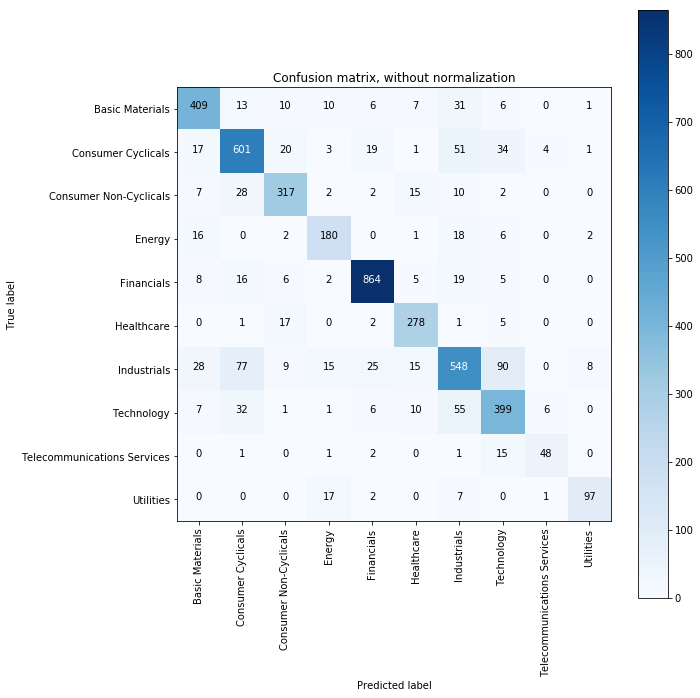

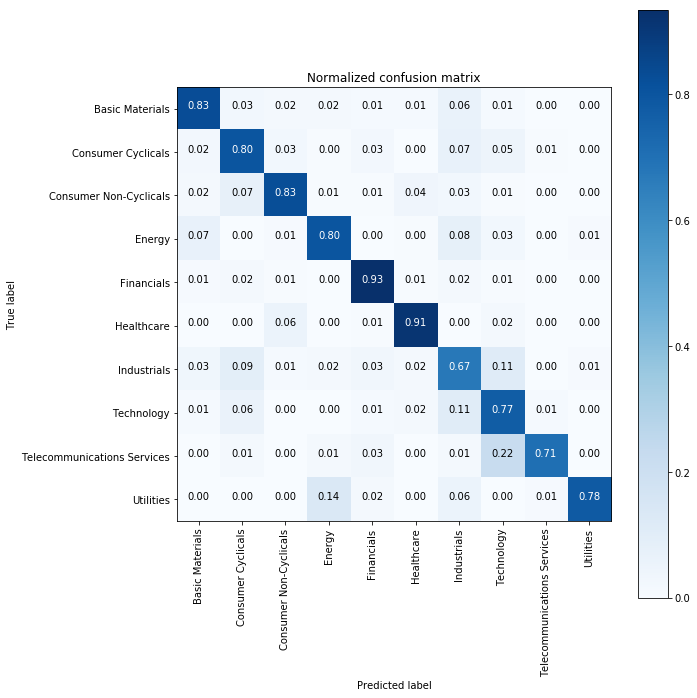

In [25]:
import itertools
import matplotlib.pyplot as plt

class_names = ['Basic Materials', 'Consumer Cyclicals', 'Consumer Non-Cyclicals', 'Energy', 'Financials', 'Healthcare', 
               'Industrials', 'Technology', 'Telecommunications Services', 'Utilities']

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Adapted from sklearn:
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test.argmax(axis=1), test_predictions.argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                  title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                  title='Normalized confusion matrix')

plt.show()